# Sentiment Analysis and Rating Prediction of Movie Reviews

Apply Natural Language Processing (NLP) techniques to analyze a dataset of movie reviews. Tools used to explore, analyze, and model text data include: 
* NLTK
* Spacy
* WordCloud
* Scikt-Learn

## Goal: 

Establish a relationship between the textual content of the reviews and their associated ratings and subsequently predict these ratings

## Data Preprocessing

In [1]:
#load the needed libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
import nltk
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
import joblib
import re
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', 250)

#### NLP Functions

In [2]:
#load the needed functions
def preprocess_text(txt, nlp=None, remove_stopwords=True, remove_punct=True, use_lemmas=False):
    if nlp is None:
        nlp = spacy.load('en_core_web_sm')

    doc = nlp(txt)

    # Saving list of the token objects for stopwords and punctuation removal
    tokens = []

    for token in doc:
        # Check if should remove stopwords and if token is stopword
        if (remove_stopwords == True) & (token.is_stop == True):
            # Continue the loop with the next token
            continue

        # Check if should remove punctuation and if token is punctuation
        if (remove_punct == True) & (token.is_punct == True):
            # Continue the loop with the next oken
            continue

        # Check if should remove punctation and if token is space
        if (remove_punct == True) & (token.is_space == True):
            continue

        # Determine final form of output list of tokens/lemmas
        if use_lemmas:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text.lower())

    return tokens

In [3]:
#custom nlp function
def make_custom_nlp(
    disable=["ner"],
    contractions=["don't", "can't", "couldn't", "you'd", "I'll"],
    stopwords_to_add=[],
    stopwords_to_remove=[],
    spacy_model = "en_core_web_sm"
):
    # Load the English NLP model
    nlp = spacy.load(spacy_model, disable=disable)
    
    # Adding Special Cases 
    # Loop through the contractions list and add special cases
    for contraction in contractions:
        special_case = [{"ORTH": contraction}]
        nlp.tokenizer.add_special_case(contraction, special_case)
    
    # Adding stopwords
    for word in stopwords_to_add:
        # Set the is_stop attribute for the word in the vocab dict to true.
        nlp.vocab[
            word
        ].is_stop = True  # this determines spacy's treatmean of the word as a stop word
        # Add the word to the list of stopwords (for easily tracking stopwords)
        nlp.Defaults.stop_words.add(word)
    
    # Removing Stopwords
    for word in stopwords_to_remove:
        
        # Ensure the words are not recognized as stopwords
        nlp.vocab[word].is_stop = False
        nlp.Defaults.stop_words.discard(word)
        
    return nlp

In [4]:
#customize nlp pipeline
nlp_light = make_custom_nlp(disable=['ner', 'parser', 'recognizer'], contractions=[], 
                           stopwords_to_add=["★"])

#### N-Gram Functions

In [5]:
#load the needed functions
def get_ngram_measures_finder(tokens, ngrams=2, get_scores_df=False, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [6]:
def plot_ngrams(df, title, first_col_group=None, second_col_group=None, freq_type=None):
    """
    Plot bar plots for both high and low ngrams.

    Make sure to reindex the data or you will get errors: e.g df=token_bigram.reindex()

    Parameters:
    - df: DataFrame with MultiIndex columns
    - title: Title for the overall graph
    - first_col_group: Name of the "1st Group" column
    - second_col_group: Name of the "2nd Group" column
    - freq_type: Frequency type to plot
    """
    plt.figure(figsize=(14, 6))

    # Plot for High Token Rating Reviews
    first_col_group_name = [col for col in df.columns.levels[0] if first_col_group.lower() in col.lower()][0]
    plt.subplot(1, 2, 1)
    sns.barplot(x=df[(first_col_group_name, 'Words')], y=df[(first_col_group_name, freq_type)])
    plt.title(f'{first_col_group}')
    plt.xlabel('Words')
    plt.ylabel(freq_type)
    plt.xticks(rotation=90)

    # Plot for Low Token Rating Reviews
    second_col_group_name = [col for col in df.columns.levels[0] if second_col_group.lower() in col.lower()][0]
    plt.subplot(1, 2, 2)
    sns.barplot(x=df[(second_col_group_name, 'Words')], y=df[(second_col_group_name, freq_type)])
    plt.title(f'{second_col_group}')
    plt.xlabel('Words')
    plt.ylabel(freq_type)
    plt.xticks(rotation=90)

    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

In [7]:
#load dataset
df = pd.read_csv("Data-NLP/movie_reviews_v2.csv")
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0


In [8]:
#inspect the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


In [9]:
#remove missing values 
df = df.dropna(subset=['rating'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7454 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       7454 non-null   object 
 1   movie_id        7454 non-null   int64  
 2   imdb_id         7454 non-null   object 
 3   original_title  7454 non-null   object 
 4   review          7454 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 407.6+ KB


In [10]:
#check for duplicates
df.duplicated().any()

False

<Axes: xlabel='rating', ylabel='Count'>

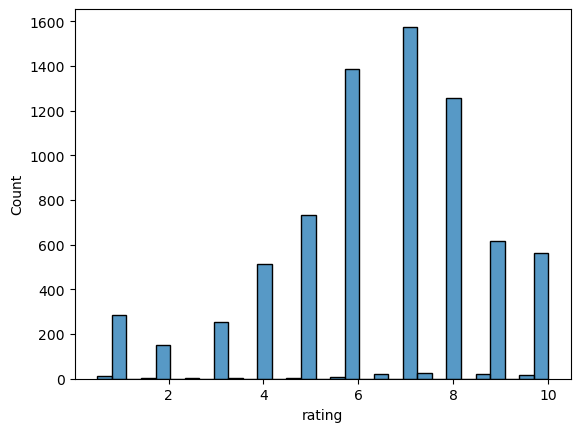

In [11]:
#check distribution of ratings
sns.histplot(df['rating'])

In [12]:
#create function to define high-rating and high-rating reviews
def categorize_rating(rating):
    if rating >=9:
        return 'High'
    elif rating <=4:
        return 'Low'
    else:
        return None

In [13]:
#use the rating column to create a new target column with high-rating and low-rating
df['rating_category'] = df['rating'].apply(categorize_rating)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None


In [14]:
#check rating_category column
df['rating_category'].value_counts(normalize=True)

Low     0.505994
High    0.494006
Name: rating_category, dtype: float64

### NLTK and SpaCy for basic text processing

In [15]:
%%time
#tokenized data
df['tokens'] = df['review'].map(lambda txt: preprocess_text(txt, nlp=nlp_light))
df.head()

CPU times: user 1min 39s, sys: 3.55 s, total: 1min 43s
Wall time: 1min 42s


,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]"
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]"
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul..."
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, addin..."


In [16]:
%%time
#lemmatized columns
df['lemmas'] = df['review'].map(lambda txt: preprocess_text(txt, nlp=nlp_light, use_lemmas=True))
df.head()

CPU times: user 1min 34s, sys: 3.38 s, total: 1min 37s
Wall time: 1min 37s


,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]"
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]"
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'Chicken, Run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly..."
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, addin...","[ok, huge, temptation, riddle, review, pun, go, crack, little, family, adventure, seemingly, base, range, classic, movie, Great, escape, Star, Trek, Love, Story, score, cannibalise, write, Messrs., Korngold, Williams, Bernstein, add, super, stop,..."


In [17]:
#joined tokenize
df['tokens-joined'] = df['tokens'].map(lambda txt: ' '.join(txt))
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'Chicken, Run'</em, >, watch, crap, tonne, little, vast, number, year, impressive, production, give, come, 2000, despite, pretty, simple, feel, film, develop, concept, admittedly, short, run, time, truly, fly...",good stop motion animation < em>'chicken run'</em > watched crap tonne little vast number years impressive production given came 2000 despite pretty simple feel film developed concept admittedly short run time truly flies course looks relatively ...
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - bu

In [18]:
#joined lemmnans
df['lemmas-joined'] = df['lemmas'].map(lambda txt: ' '.join(txt))
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'Chicken, Run'</em, >, watch

In [19]:
#save preprocessed data frame in a joblib file for future modeling
joblib.dump(df, "Data-NLP/processed-data.joblib")

['Data-NLP/processed-data.joblib']

In [20]:
#ensure it works
loaded = joblib.load("Data-NLP/processed-data.joblib")
loaded.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'Chicken, Run'</em, >, watch

## EDA and Visualization

In [21]:
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the fi...",8.0,None,"[good, stop, motion, animation, <, em>'chicken, run'</em, >, watched, crap, tonne, little, vast, number, years, impressive, production, given, came, 2000, despite, pretty, simple, feel, film, developed, concept, admittedly, short, run, time, trul...","[good, stop, motion, animation, <, em>'Chicken, Run'</em, >, watch

In [22]:
#reviews can contain HTML code, function to determine how many
def has_html(data):
    pattern = re.compile(r'<.*?>|https?')
    text = ' '.join(data)
    matches = pattern.findall(text)
    count = len(matches)
    if count > 0:
        print(f"Total HTML Occurences: {count}")
    no_html = data.apply(lambda x: not bool(pattern.search(x)))
    rows_affected = len(no_html) - no_html.sum()
    print(f"Total rows affected with HTML code {rows_affected}")
    return no_html

In [23]:
#find rows in the data that has html
no_html_rows = has_html(df['review'])

Total HTML Occurences: 2042
Total rows affected with HTML code 846


In [24]:
df_clean = df[no_html_rows]
df_clean

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, addin...","[ok, huge, temptation, riddle, review, pun, go, crack, littl

In [25]:
#verify review column has no html
no_html = df_clean['review'].str.contains(r'<.*?>', regex=True, na=False)
no_html.sum()

0

In [26]:
#save the additionally cleaned data
joblib.dump(df_clean, "Data-NLP/processed-data-no-html.joblib")

['Data-NLP/processed-data-no-html.joblib']

### WordCloud

In [27]:
custom_stopwords = [*STOPWORDS]

In [28]:
#create variables for high and low reviews
high_ratings = df_clean[df_clean['rating_category'] == "High"]
low_ratings = df_clean[df_clean['rating_category']== "Low"]

In [29]:
#make a single giant string with entire group of high and low reviews
#for each token-joined and lemmas-joined
token_high_ratings_text = ' '.join(high_ratings.loc[:, 'tokens-joined'])
token_low_ratings_text = ' '.join(low_ratings.loc[:, 'tokens-joined'])

lemmas_high_ratings_text = ' '.join(high_ratings.loc[:, 'lemmas-joined'])
lemmas_low_ratings_text = ' '.join(low_ratings.loc[:, 'lemmas-joined'])

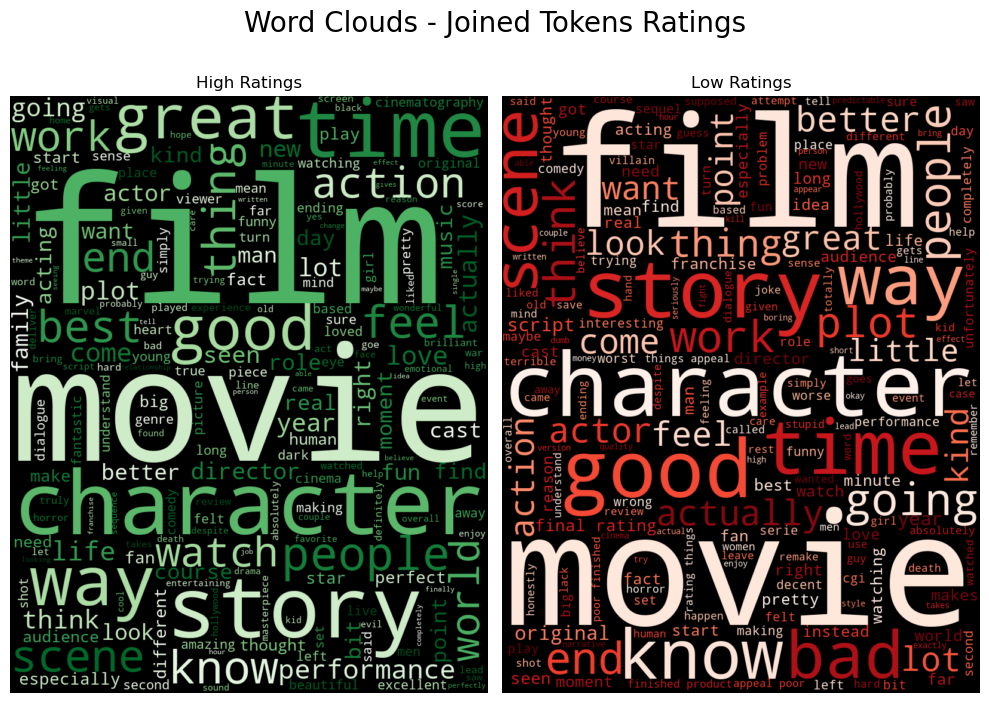

In [30]:
#create the Word Cloud for tokens-joined
tokens_high_ratings_cloud = WordCloud(random_state = 42,
                                      width = 800,
                                      height = 1000,
                                      min_word_length=2,
                                      colormap="Greens",
                                      stopwords=custom_stopwords).generate(token_high_ratings_text)
tokens_low_ratings_cloud = WordCloud(random_state = 42,
                                     width = 800,
                                     height= 1000,
                                     min_word_length = 2,
                                     colormap="Reds",
                                     stopwords=custom_stopwords).generate(token_low_ratings_text)

fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(tokens_high_ratings_cloud, interpolation='bilinear')
axes[0].set_title("High Ratings")
axes[1].imshow(tokens_low_ratings_cloud, interpolation='bilinear')
axes[1].set_title("Low Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Joined Tokens Ratings', fontsize=20, y=1.05);
fig.savefig("Images/WordCloud-Joined-Tokens.png", dpi=300, transparent=False, bbox_inches='tight')

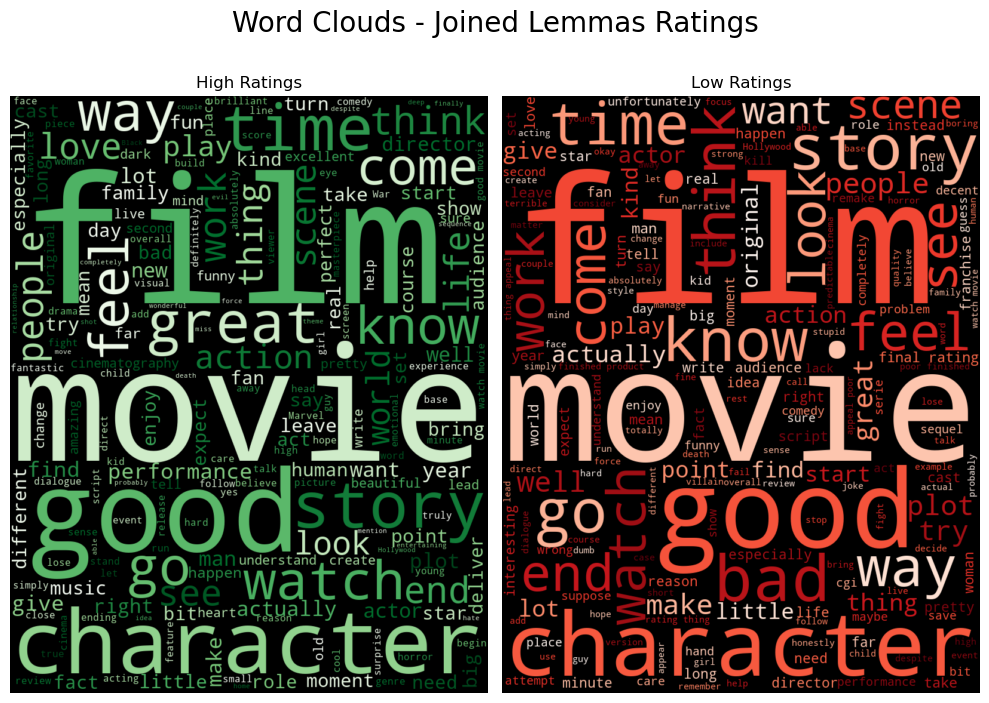

In [31]:
#create the Word Cloud for lemmas-joined
lemmas_high_ratings_cloud = WordCloud(random_state = 42,
                                      width = 800,
                                      height = 1000,
                                      min_word_length=2,
                                      colormap="Greens",
                                      stopwords=custom_stopwords).generate(lemmas_high_ratings_text)
lemmas_low_ratings_cloud = WordCloud(random_state = 42,
                                     width = 800,height= 1000,
                                     min_word_length = 2,
                                     colormap="Reds",
                                     stopwords=custom_stopwords).generate(lemmas_low_ratings_text)

fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(lemmas_high_ratings_cloud, interpolation='bilinear')
axes[0].set_title("High Ratings")
axes[1].imshow(lemmas_low_ratings_cloud, interpolation='bilinear')
axes[1].set_title("Low Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Joined Lemmas Ratings', fontsize=20, y=1.05);
fig.savefig("Images/WordCloud-Joined-Lemmas.png", dpi=300, transparent=False, bbox_inches='tight')

### NlTK's FreqDist

In [32]:
#explode tokens and lemmas reviews and convert to list
high_rating_tokens_list = high_ratings['tokens'].explode().to_list()
low_rating_tokens_list = low_ratings['tokens'].explode().to_list()

high_rating_lemmas_list = high_ratings['lemmas'].explode().to_list()
low_rating_lemmas_list = low_ratings['lemmas'].explode().to_list()

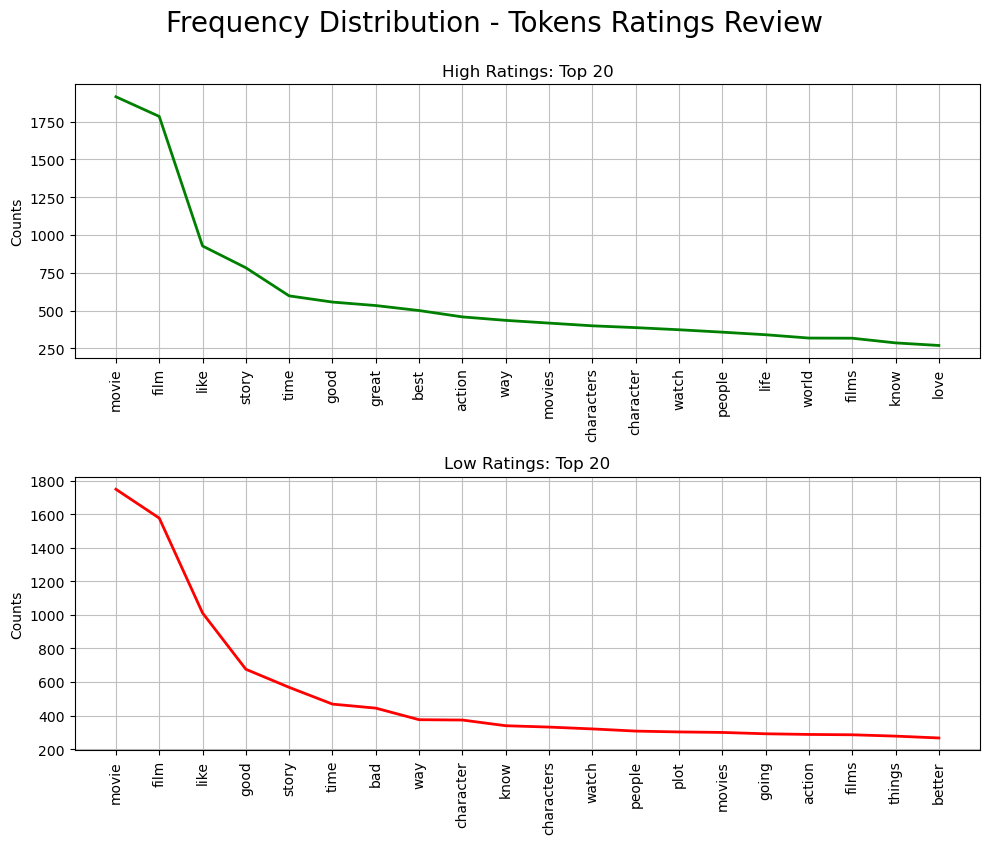

In [33]:
#create FreqDist for tokens
tokens_high_freqdist = FreqDist(high_rating_tokens_list)
tokens_low_freqdist = FreqDist(low_rating_tokens_list)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

plt.sca(axes[0])
tokens_high_freqdist.plot(20, show=False, color='green')
plt.title('High Ratings: Top 20')
axes[0].set_xlabel('')

plt.sca(axes[1])
tokens_low_freqdist.plot(20, show=False, color='red')
plt.title('Low Ratings: Top 20')
axes[1].set_xlabel('')

fig.tight_layout();
fig.suptitle('Frequency Distribution - Tokens Ratings Review', fontsize=20, y=1.05)
fig.savefig("Images/FreqDist-Tokens.png", dpi=300, transparent=False, bbox_inches='tight')

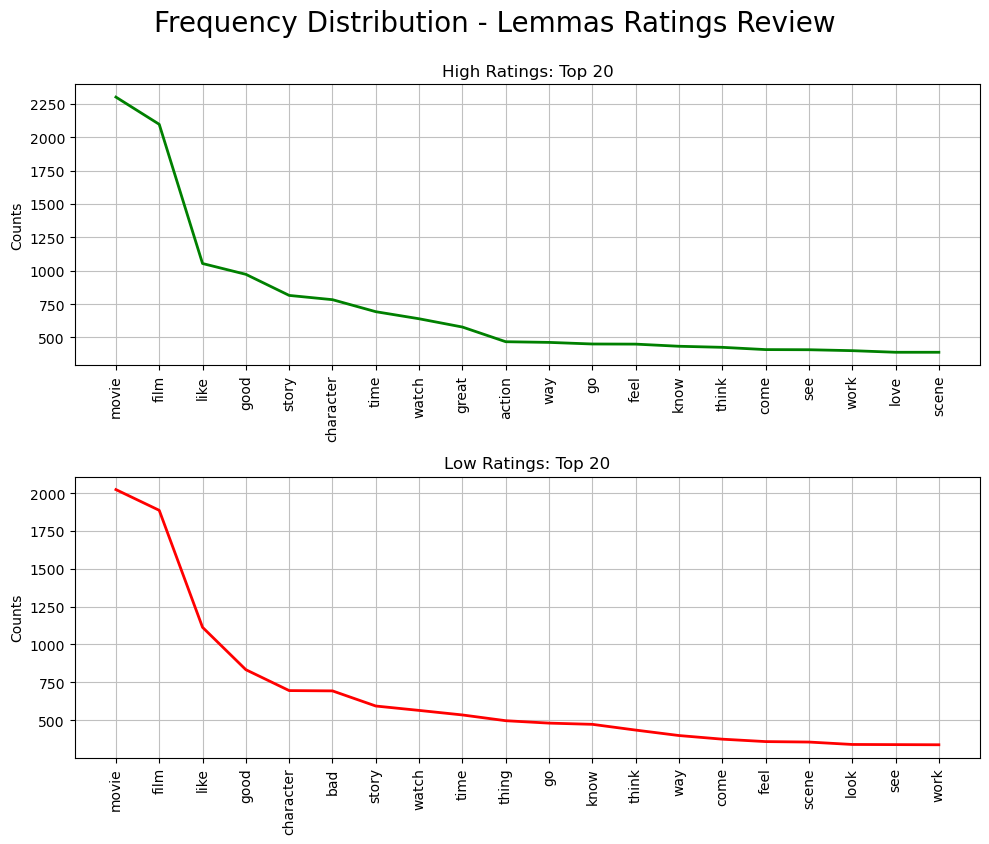

In [34]:
#create FreqDist for lemmas
lemmas_high_freqdist = FreqDist(high_rating_lemmas_list)
lemmas_low_freqdist = FreqDist(low_rating_lemmas_list)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

plt.sca(axes[0])
lemmas_high_freqdist.plot(20, show=False, color='green')
plt.title('High Ratings: Top 20')
axes[0].set_xlabel('')

plt.sca(axes[1])
lemmas_low_freqdist.plot(20, show=False, color='red')
plt.title('Low Ratings: Top 20')
axes[1].set_xlabel('')

fig.tight_layout();
fig.suptitle('Frequency Distribution - Lemmas Ratings Review', fontsize=20, y=1.05)
fig.savefig("Images/FreqDist-Lemmas.png", dpi=300, transparent=False, bbox_inches='tight');

### N-Gram Analysis

#### Bigrams - Raw Frequency

In [35]:
#use custom function to obtain BigramAssocMeasures raw frequency tokens
token_bigram_raw_high = get_ngram_measures_finder(high_rating_tokens_list)
token_bigram_raw_high.head()

,Words,Raw Freq
0,"(comic, book)",0.000488
1,"(special, effects)",0.000488
2,"(sci, fi)",0.000421
3,"(star, wars)",0.000413
4,"(action, movie)",0.000387


In [36]:
#use custom function to obtain BigramAssocMeasures raw frequency tokens
token_bigram_raw_low = get_ngram_measures_finder(low_rating_tokens_list)
token_bigram_raw_low.head()

,Words,Raw Freq
0,"(final, rating)",0.001247
1,"(finished, product)",0.000935
2,"(appeal, poor)",0.000925
3,"(poor, finished)",0.000925
4,"(rating, things)",0.000925


In [37]:
#combine tokens dataframe
df_tokens_bigrams_raw = pd.concat([token_bigram_raw_high, token_bigram_raw_low], 
                             axis=1, 
                             keys=["High Token Rating Reviews", "Low Token Rating Reviews"])
df_tokens_bigrams_raw.head()

High Token Rating Reviews           Low Token Rating Reviews          
                      Words  Raw Freq                    Words  Raw Freq
0             (comic, book)  0.000488          (final, rating)  0.001247
1        (special, effects)  0.000488      (finished, product)  0.000935
2                 (sci, fi)  0.000421           (appeal, poor)  0.000925
3              (star, wars)  0.000413         (poor, finished)  0.000925
4           (action, movie)  0.000387         (rating, things)  0.000925

In [38]:
#use custom function to obtain BigramAssocMeasures raw frequency lemmas
lemmas_bigram_raw_high = get_ngram_measures_finder(high_rating_lemmas_list)
lemmas_bigram_raw_high.head()

,Words,Raw Freq
0,"(feel, like)",0.000783
1,"(watch, movie)",0.000699
2,"(good, movie)",0.000682
3,"(comic, book)",0.000530
4,"(action, movie)",0.000514


In [39]:
#use custom function to obtain BigramAssocMeasures raw frequency lemmas
lemmas_bigram_raw_low = get_ngram_measures_finder(low_rating_lemmas_list)
lemmas_bigram_raw_low.head()

,Words,Raw Freq
0,"(final, rating)",0.001247
1,"(feel, like)",0.001149
2,"(finished, product)",0.000935
3,"(appeal, poor)",0.000925
4,"(poor, finished)",0.000925


In [40]:
#combine lemmas dataframe
df_lemmas_bigrams_raw = pd.concat([lemmas_bigram_raw_high, lemmas_bigram_raw_low], 
                             axis=1, 
                             keys=["High Lemmas Rating Reviews", "Low Lemmas Rating Reviews"])
df_lemmas_bigrams_raw.head()

High Lemmas Rating Reviews           Low Lemmas Rating Reviews          
                       Words  Raw Freq                     Words  Raw Freq
0               (feel, like)  0.000783           (final, rating)  0.001247
1             (watch, movie)  0.000699              (feel, like)  0.001149
2              (good, movie)  0.000682       (finished, product)  0.000935
3              (comic, book)  0.000530            (appeal, poor)  0.000925
4            (action, movie)  0.000514          (poor, finished)  0.000925

In [41]:
#convert tokens bigrams into a markdown table
md_tokens_bigrams = df_tokens_bigrams_raw.head(10).to_markdown(index=False)
print(md_tokens_bigrams)

| ('High Token Rating Reviews', 'Words')   |   ('High Token Rating Reviews', 'Raw Freq') | ('Low Token Rating Reviews', 'Words')   |   ('Low Token Rating Reviews', 'Raw Freq') |
|:-----------------------------------------|--------------------------------------------:|:----------------------------------------|-------------------------------------------:|
| ('comic', 'book')                        |                                 0.000488388 | ('final', 'rating')                     |                                0.00124658  |
| ('special', 'effects')                   |                                 0.000488388 | ('finished', 'product')                 |                                0.000934934 |
| ('sci', 'fi')                            |                                 0.000421024 | ('appeal', 'poor')                      |                                0.000925196 |
| ('star', 'wars')                         |                                 0.000412604 | ('poor', 'finished'

In [42]:
#save tokens bigrams markdown table
with open ('Data-NLP/md_tokens_bigrams_raw.md', 'w') as f:
    f.write(md_tokens_bigrams)

In [43]:
#convert lemmas bigrams into a markdown table
md_lemmas_bigrams = df_lemmas_bigrams_raw.head(10).to_markdown(index=False)
print(md_lemmas_bigrams)

| ('High Lemmas Rating Reviews', 'Words')   |   ('High Lemmas Rating Reviews', 'Raw Freq') | ('Low Lemmas Rating Reviews', 'Words')   |   ('Low Lemmas Rating Reviews', 'Raw Freq') |
|:------------------------------------------|---------------------------------------------:|:-----------------------------------------|--------------------------------------------:|
| ('feel', 'like')                          |                                  0.000783105 | ('final', 'rating')                      |                                 0.00124658  |
| ('watch', 'movie')                        |                                  0.0006989   | ('feel', 'like')                         |                                 0.00114919  |
| ('good', 'movie')                         |                                  0.000682059 | ('finished', 'product')                  |                                 0.000934934 |
| ('comic', 'book')                         |                                  0.000530491

In [44]:
#save tokens bigrams markdown table
with open ('Data-NLP/md_lemmas_bigrams_raw.md', 'w') as f:
    f.write(md_lemmas_bigrams)

#### Bigrams - PMI

In [45]:
#pmi for high and low token
token_bigram_pmi_high = get_ngram_measures_finder(high_rating_tokens_list,
                                                 measure='pmi', top_n=10,
                                                 min_freq=10)
token_bigram_pmi_low = get_ngram_measures_finder(low_rating_tokens_list,
                                                 measure='pmi', top_n=10,
                                                 min_freq=10)

In [46]:
#combine token dataframe
df_tokens_bigrams_pmi = pd.concat([token_bigram_pmi_high, token_bigram_pmi_low], 
                             axis=1, 
                             keys=["High Token Rating Reviews", "Low Token Rating Reviews"])
df_tokens_bigrams_pmi.head()

High Token Rating Reviews            Low Token Rating Reviews           
                      Words        Pmi                    Words        Pmi
0                 (gon, na)  13.272703              (del, toro)  13.325882
1            (los, angeles)  13.157225            (vin, diesel)  12.947370
2           (martial, arts)  12.916217                (gon, na)  12.947370
3     (scarlett, johansson)  12.687740          (martial, arts)  12.702951
4          (suicide, squad)  12.671799        (hercule, poirot)  12.062847

In [47]:
#convert bigrams pmi into markdown table and save
md_token_bigrams_pmi = df_tokens_bigrams_pmi.head(10).to_markdown(index=False)
with open ('Data-NLP/md_tokens_bigrams_pmi.md', 'w') as f:
    f.write(md_token_bigrams_pmi)
print(md_token_bigrams_pmi)

| ('High Token Rating Reviews', 'Words')   |   ('High Token Rating Reviews', 'Pmi') | ('Low Token Rating Reviews', 'Words')   |   ('Low Token Rating Reviews', 'Pmi') |
|:-----------------------------------------|---------------------------------------:|:----------------------------------------|--------------------------------------:|
| ('gon', 'na')                            |                                13.2727 | ('del', 'toro')                         |                               13.3259 |
| ('los', 'angeles')                       |                                13.1572 | ('vin', 'diesel')                       |                               12.9474 |
| ('martial', 'arts')                      |                                12.9162 | ('gon', 'na')                           |                               12.9474 |
| ('scarlett', 'johansson')                |                                12.6877 | ('martial', 'arts')                     |                               12

In [48]:
#pmi for high and low lemmas
lemmas_bigram_pmi_high = get_ngram_measures_finder(high_rating_lemmas_list,
                                                 measure='pmi', top_n=10,
                                                 min_freq=10)
lemmas_bigram_pmi_low = get_ngram_measures_finder(low_rating_lemmas_list,
                                                 measure='pmi', top_n=10,
                                                 min_freq=10)

In [49]:
#combine lemmas dataframe
df_lemmas_bigrams_pmi = pd.concat([lemmas_bigram_pmi_high, lemmas_bigram_pmi_low], 
                             axis=1, 
                             keys=["High Lemmas Rating Reviews", "Low Lemmas Rating Reviews"])
df_lemmas_bigrams_pmi.head()

High Lemmas Rating Reviews            Low Lemmas Rating Reviews           
                       Words        Pmi                     Words        Pmi
0           (United, States)  13.535737             (Vin, Diesel)  12.947370
1           (Suicide, Squad)  13.272703           (Wonder, Woman)  12.947370
2             (Los, Angeles)  13.157225            (Silver, Lake)  12.740919
3                 (Blu, ray)  12.924779          (Suicide, Squad)  12.740919
4      (Scarlett, Johansson)  12.687740         (Hercule, Poirot)  12.062847

In [50]:
#convert bigrams pmi into markdown table and save
md_lemmas_bigrams_pmi = df_lemmas_bigrams_pmi.head(10).to_markdown(index=False)
with open ('Data-NLP/md_lemmas_bigrams_pmi.md', 'w') as f:
    f.write(md_lemmas_bigrams_pmi)
print(md_lemmas_bigrams_pmi)

| ('High Lemmas Rating Reviews', 'Words')   |   ('High Lemmas Rating Reviews', 'Pmi') | ('Low Lemmas Rating Reviews', 'Words')   |   ('Low Lemmas Rating Reviews', 'Pmi') |
|:------------------------------------------|----------------------------------------:|:-----------------------------------------|---------------------------------------:|
| ('United', 'States')                      |                                 13.5357 | ('Vin', 'Diesel')                        |                                12.9474 |
| ('Suicide', 'Squad')                      |                                 13.2727 | ('Wonder', 'Woman')                      |                                12.9474 |
| ('Los', 'Angeles')                        |                                 13.1572 | ('Silver', 'Lake')                       |                                12.7409 |
| ('Blu', 'ray')                            |                                 12.9248 | ('Suicide', 'Squad')                     |          

#### Trigrams - Raw Freq

In [51]:
#raw frew for high and low token
token_trigrams_raw_high = get_ngram_measures_finder(high_rating_tokens_list,
                                                  measure='raw_freq', top_n=10,
                                                  min_freq=10,
                                                  ngrams=3)
token_trigrams_raw_low = get_ngram_measures_finder(low_rating_tokens_list,
                                                 measure='raw_freq', top_n=10,
                                                 ngrams=3,
                                                 min_freq=10)

In [52]:
#combine token dataframe
df_tokens_trigrams_raw = pd.concat([token_trigrams_raw_high, token_trigrams_raw_low], 
                             axis=1, 
                             keys=["High Token Rating Reviews", "Low Token Rating Reviews"])
df_tokens_trigrams_raw.head()

High Token Rating Reviews             Low Token Rating Reviews          
                      Words  Raw Freq                      Words  Raw Freq
0                 (=, =, =)  0.000236   (appeal, poor, finished)  0.000925
1                 (⭐, ⭐, ⭐)  0.000168    (final, rating, things)  0.000925
2         (thin, red, line)  0.000101  (poor, finished, product)  0.000925
3                       NaN       NaN   (rating, things, appeal)  0.000925
4                       NaN       NaN     (things, appeal, poor)  0.000925

In [53]:
#convert trigrams into markdown table and save
md_token_trigram_raw = df_tokens_trigrams_raw.head(10).to_markdown(index=False)
with open ('Data-NLP/md_token_trigram_raw.md', 'w') as f:
    f.write(md_token_trigram_raw)
print(md_token_trigram_raw)

| ('High Token Rating Reviews', 'Words')   |   ('High Token Rating Reviews', 'Raw Freq') | ('Low Token Rating Reviews', 'Words')   |   ('Low Token Rating Reviews', 'Raw Freq') |
|:-----------------------------------------|--------------------------------------------:|:----------------------------------------|-------------------------------------------:|
| ('=', '=', '=')                          |                                 0.000235774 | ('appeal', 'poor', 'finished')          |                                0.000925196 |
| ('⭐', '⭐', '⭐')                       |                                 0.00016841  | ('final', 'rating', 'things')           |                                0.000925196 |
| ('thin', 'red', 'line')                  |                                 0.000101046 | ('poor', 'finished', 'product')         |                                0.000925196 |
| nan                                      |                               nan           | ('rating', 'things', '

In [54]:
#raw freq for high and low lemmas
lemmas_trigrams_raw_high = get_ngram_measures_finder(high_rating_lemmas_list,
                                                  measure='raw_freq', top_n=10,
                                                  min_freq=10,
                                                  ngrams=3)
lemmas_trigrams_raw_low = get_ngram_measures_finder(low_rating_lemmas_list,
                                                 measure='raw_freq', top_n=10,
                                                 ngrams=3,
                                                 min_freq=10)

In [55]:
#combine lemmas dataframe
df_lemmas_trigrams_raw = pd.concat([lemmas_trigrams_raw_high, lemmas_trigrams_raw_low], 
                             axis=1, 
                             keys=["High Lemmas Rating Reviews", "Low Lemmas Rating Reviews"])
df_lemmas_trigrams_raw.head()

High Lemmas Rating Reviews            Low Lemmas Rating Reviews          
                       Words  Raw Freq                      Words  Raw Freq
0                  (=, =, =)  0.000236   (appeal, poor, finished)  0.000925
1                  (⭐, ⭐, ⭐)  0.000168     (final, rating, thing)  0.000925
2       (comic, book, movie)  0.000109  (poor, finished, product)  0.000925
3        (Star, Wars, movie)  0.000101    (rating, thing, appeal)  0.000925
4                        NaN       NaN      (thing, appeal, poor)  0.000925

In [56]:
#convert trigrams into markdown table and save
md_lemmas_trigram_raw = df_lemmas_trigrams_raw.head(10).to_markdown(index=False)
with open ('Data-NLP/md_lemmas_trigram_raw.md', 'w') as f:
    f.write(md_lemmas_trigram_raw)
print(md_lemmas_trigram_raw)

| ('High Lemmas Rating Reviews', 'Words')   |   ('High Lemmas Rating Reviews', 'Raw Freq') | ('Low Lemmas Rating Reviews', 'Words')   |   ('Low Lemmas Rating Reviews', 'Raw Freq') |
|:------------------------------------------|---------------------------------------------:|:-----------------------------------------|--------------------------------------------:|
| ('=', '=', '=')                           |                                  0.000235774 | ('appeal', 'poor', 'finished')           |                                 0.000925196 |
| ('⭐', '⭐', '⭐')                        |                                  0.00016841  | ('final', 'rating', 'thing')             |                                 0.000925196 |
| ('comic', 'book', 'movie')                |                                  0.000109466 | ('poor', 'finished', 'product')          |                                 0.000925196 |
| ('Star', 'Wars', 'movie')                 |                                  0.000101046 | 

#### Trigrams - PMI

In [57]:
#pmi for high and low token
token_trigrams_pmi_high = get_ngram_measures_finder(high_rating_tokens_list,
                                                  measure='pmi', top_n=10,
                                                  min_freq=10,
                                                  ngrams=3)
token_trigrams_pmi_low = get_ngram_measures_finder(low_rating_tokens_list,
                                                 measure='pmi', top_n=10,
                                                 ngrams=3,
                                                 min_freq=10)

In [58]:
#combine token dataframe
df_tokens_trigrams_pmi = pd.concat([token_trigrams_pmi_high, token_trigrams_pmi_low], 
                             axis=1, 
                             keys=["High Token Rating Reviews", "Low Token Rating Reviews"])
df_tokens_trigrams_pmi.head()

High Token Rating Reviews                     Low Token Rating Reviews  \
                      Words        Pmi                             Words   
0                 (=, =, =)  23.134836             (batman, v, superman)   
1                 (⭐, ⭐, ⭐)  22.774870             (value, avoid, costs)   
2         (thin, red, line)  21.441341              (rating:, ½, boring)   
3                       NaN        NaN               (final, rating:, ½)   
4                       NaN        NaN  (disappointing, avoid, possible)   

              
         Pmi  
0  21.604748  
1  21.122692  
2  19.839632  
3  19.457992  
4  19.274592

In [59]:
#convert trigrams into markdown table and save
md_token_trigram_pmi = df_tokens_trigrams_pmi.head(10).to_markdown(index=False)
with open ('Data-NLP/md_token_trigram_pmi.md', 'w') as f:
    f.write(md_token_trigram_pmi)
print(md_token_trigram_pmi)

| ('High Token Rating Reviews', 'Words')   |   ('High Token Rating Reviews', 'Pmi') | ('Low Token Rating Reviews', 'Words')   |   ('Low Token Rating Reviews', 'Pmi') |
|:-----------------------------------------|---------------------------------------:|:----------------------------------------|--------------------------------------:|
| ('=', '=', '=')                          |                                23.1348 | ('batman', 'v', 'superman')             |                               21.6047 |
| ('⭐', '⭐', '⭐')                       |                                22.7749 | ('value', 'avoid', 'costs')             |                               21.1227 |
| ('thin', 'red', 'line')                  |                                21.4413 | ('rating:', '½', 'boring')              |                               19.8396 |
| nan                                      |                               nan      | ('final', 'rating:', '½')               |                               19.45

In [60]:
#raw freq for high and low lemmas
lemmas_trigrams_pmi_high = get_ngram_measures_finder(high_rating_lemmas_list,
                                                  measure='pmi', top_n=10,
                                                  min_freq=10,
                                                  ngrams=3)
lemmas_trigrams_pmi_low = get_ngram_measures_finder(low_rating_lemmas_list,
                                                 measure='pmi', top_n=10,
                                                 ngrams=3,
                                                 min_freq=10)

In [61]:
#combine lemmas dataframe
df_lemmas_trigrams_pmi = pd.concat([lemmas_trigrams_pmi_high, lemmas_trigrams_pmi_low], 
                             axis=1, 
                             keys=["High Lemmas Rating Reviews", "Low Lemmas Rating Reviews"])
df_lemmas_trigrams_pmi.head()

High Lemmas Rating Reviews                  Low Lemmas Rating Reviews  \
                       Words        Pmi                           Words   
0                  (=, =, =)  23.134836            (rating:, ½, Boring)   
1                  (⭐, ⭐, ⭐)  22.774870      (½, Boring, disappointing)   
2        (Star, Wars, movie)  14.577659  (Boring, disappointing, avoid)   
3       (comic, book, movie)  12.700830            (value, avoid, cost)   
4                        NaN        NaN             (final, rating:, ½)   

              
         Pmi  
0  21.432456  
1  20.561085  
2  19.781475  
3  19.697427  
4  19.454556

In [62]:
#convert trigrams into markdown table and save
md_lemmas_trigram_pmi = df_lemmas_trigrams_pmi.head(10).to_markdown(index=False)
with open ('Data-NLP/md_lemmas_trigram_pmi.md', 'w') as f:
    f.write(md_lemmas_trigram_pmi)
print(md_lemmas_trigram_pmi)

| ('High Lemmas Rating Reviews', 'Words')   |   ('High Lemmas Rating Reviews', 'Pmi') | ('Low Lemmas Rating Reviews', 'Words')   |   ('Low Lemmas Rating Reviews', 'Pmi') |
|:------------------------------------------|----------------------------------------:|:-----------------------------------------|---------------------------------------:|
| ('=', '=', '=')                           |                                 23.1348 | ('rating:', '½', 'Boring')               |                                21.4325 |
| ('⭐', '⭐', '⭐')                        |                                 22.7749 | ('½', 'Boring', 'disappointing')         |                                20.5611 |
| ('Star', 'Wars', 'movie')                 |                                 14.5777 | ('Boring', 'disappointing', 'avoid')     |                                19.7815 |
| ('comic', 'book', 'movie')                |                                 12.7008 | ('value', 'avoid', 'cost')               |             

#### Bigrams vs. Trigram Analysis:

#### Tokens: 

In [63]:
#reindex all columns for use with top 10
token_bigram_raw = df_tokens_bigrams_raw.head(10).reindex()
token_bigram_pmi = df_tokens_bigrams_pmi.head(10).reindex()
lemmas_bigram_raw = df_lemmas_bigrams_raw.head(10).reindex()
lemmas_bigram_pmi = df_lemmas_bigrams_pmi.head(10).reindex()
token_trigram_raw = df_tokens_trigrams_raw.head(10).reindex()
token_trigram_pmi = df_tokens_trigrams_pmi.head(10).reindex()
lemmas_trigram_raw = df_lemmas_trigrams_raw.head(10).reindex()
lemmas_trigram_pmi = df_lemmas_trigrams_pmi.head(10).reindex()

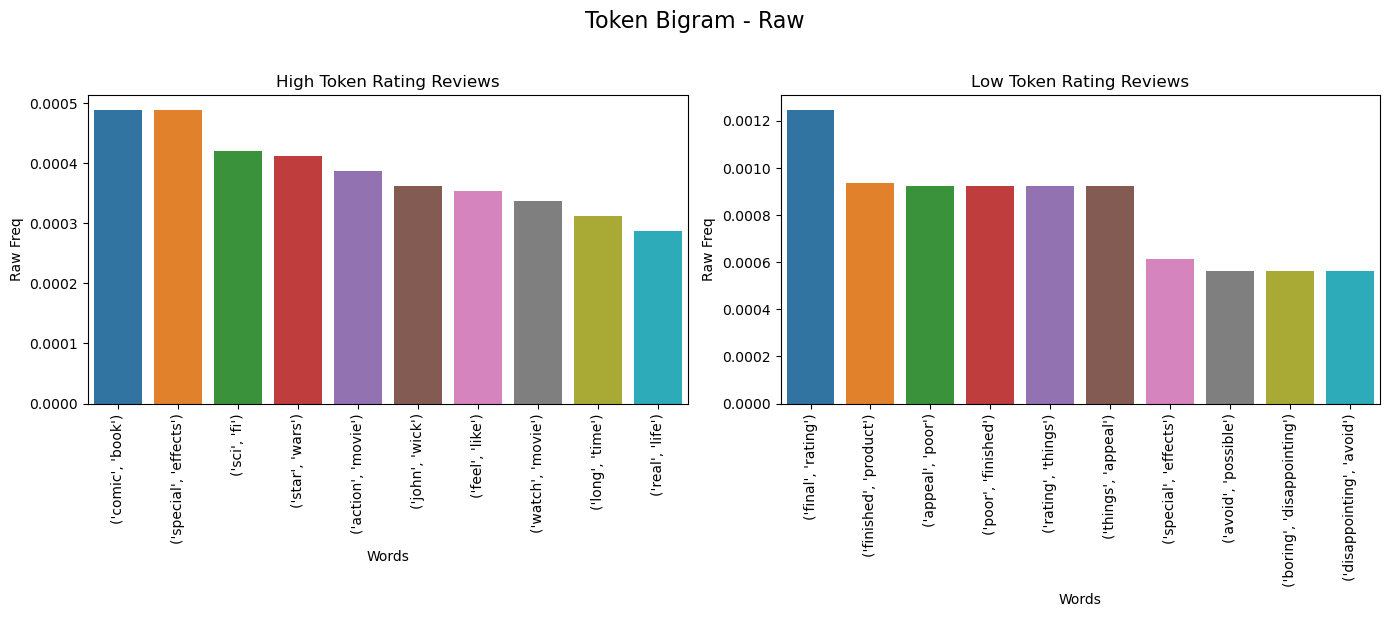

In [64]:
#tokens raw bigram
plot_ngrams(token_bigram_raw, title='Token Bigram - Raw',
            first_col_group='High Token Rating Reviews', 
            second_col_group='Low Token Rating Reviews', 
            freq_type='Raw Freq')

/var/folders/tc/tt7jrftn7g510vxnf1thdhl80000gn/T/ipykernel_55383/1440420602.py:35: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


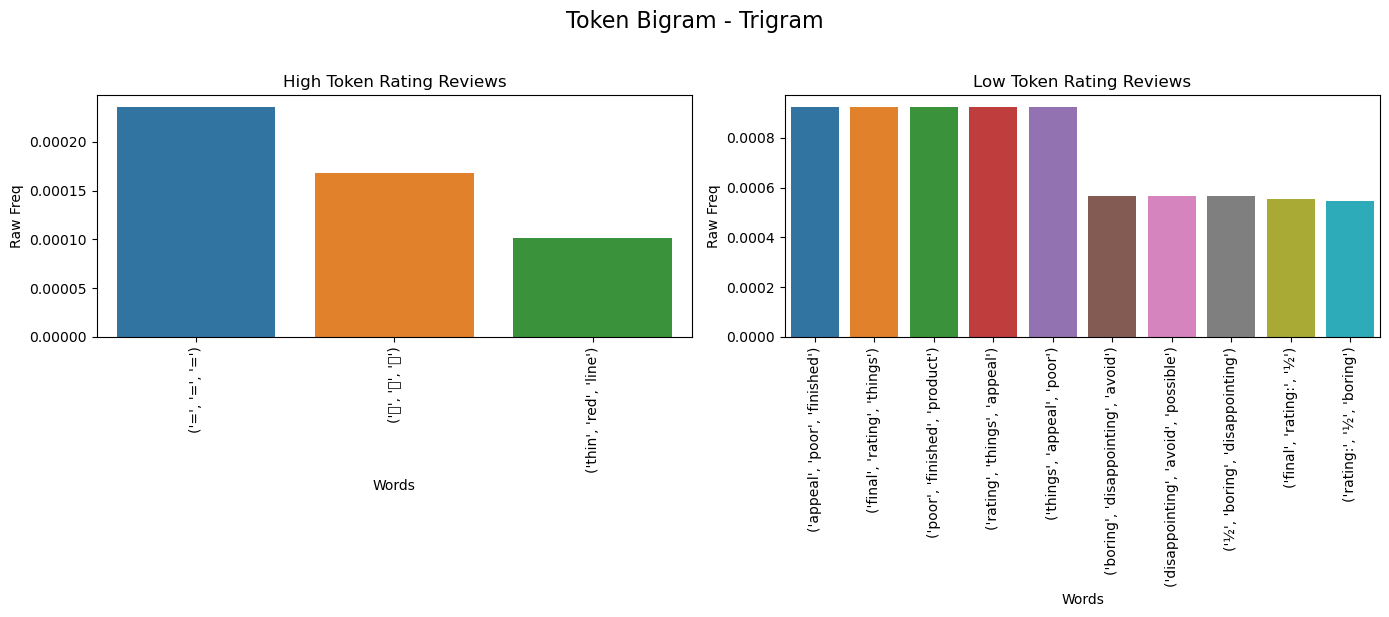

In [65]:
#tokens raw trigram
plot_ngrams(token_trigram_raw, title='Token Bigram - Trigram',
            first_col_group='High Token Rating Reviews', 
            second_col_group='Low Token Rating Reviews', 
            freq_type='Raw Freq')

##### Token Bigram Raw vs Token Trigram Raw Analysis: 
Although trigram is considered "more accurate", analyzing the graph above shows a different story. By using trigram, there are less common word patterns to determine a high review. This could introduce potential mismatches. 

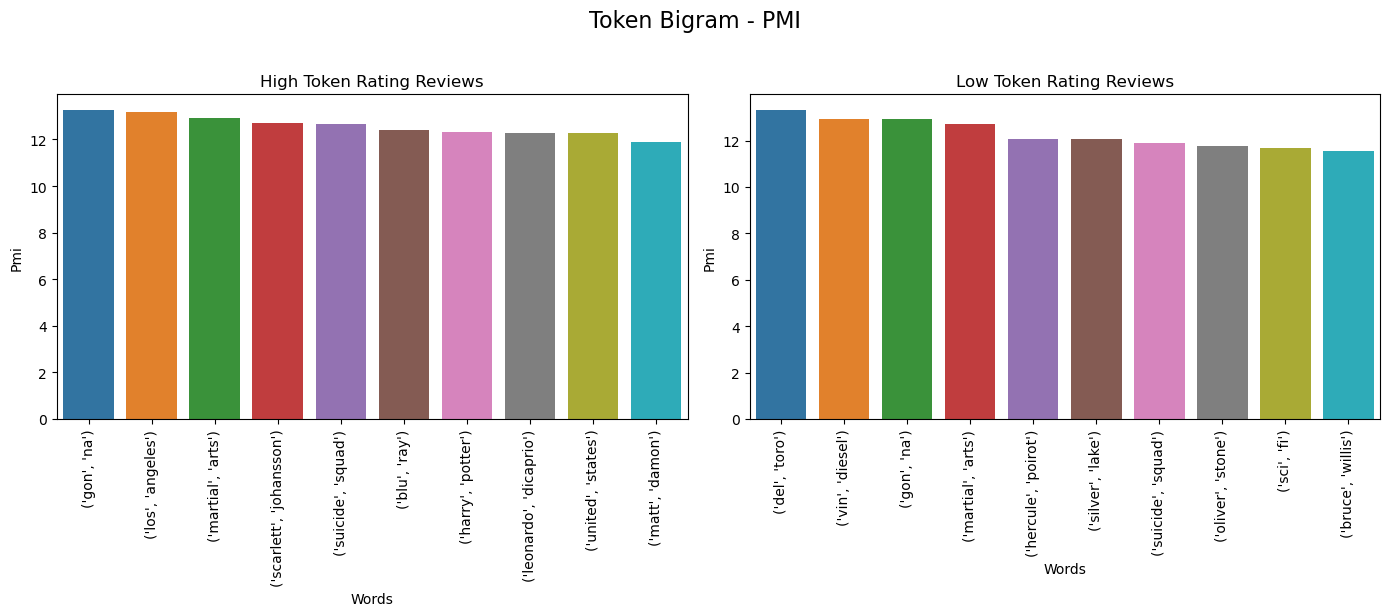

In [66]:
#tokens pmi bigram
plot_ngrams(token_bigram_pmi, title='Token Bigram - PMI',
            first_col_group='High Token Rating Reviews', 
            second_col_group='Low Token Rating Reviews', 
            freq_type='Pmi')

/var/folders/tc/tt7jrftn7g510vxnf1thdhl80000gn/T/ipykernel_55383/1440420602.py:35: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


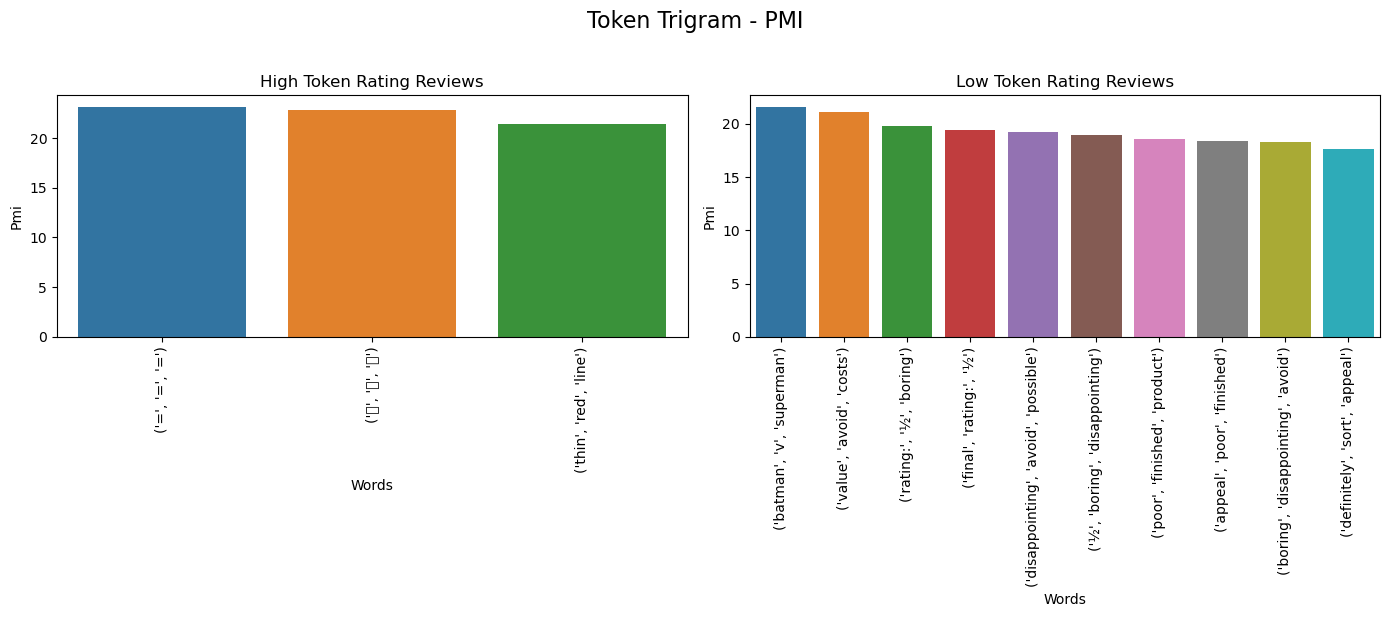

In [67]:
#tokens pmi trigram
plot_ngrams(token_trigram_pmi, title='Token Trigram - PMI',
            first_col_group='High Token Rating Reviews', 
            second_col_group='Low Token Rating Reviews', 
            freq_type='Pmi')

##### Token Bigram PMI vs Token Trigram PMI Analysis: 
We can see the same potential issue here that was analyzed in the Bigram Raw and Trigram Raw of the tokens. 

#### Lemmas:

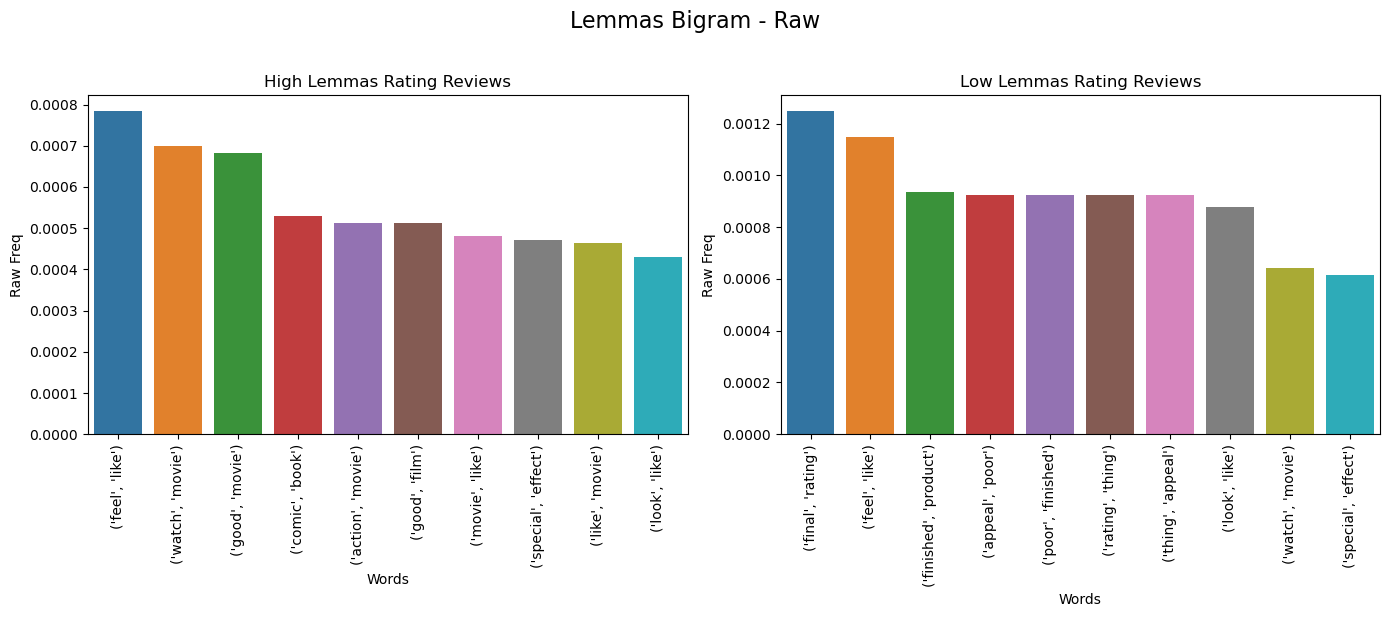

In [68]:
#lemmas raw bigram
plot_ngrams(lemmas_bigram_raw, title='Lemmas Bigram - Raw',
            first_col_group='High Lemmas Rating Reviews', 
            second_col_group='Low Lemmas Rating Reviews', 
            freq_type='Raw Freq')

/var/folders/tc/tt7jrftn7g510vxnf1thdhl80000gn/T/ipykernel_55383/1440420602.py:35: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


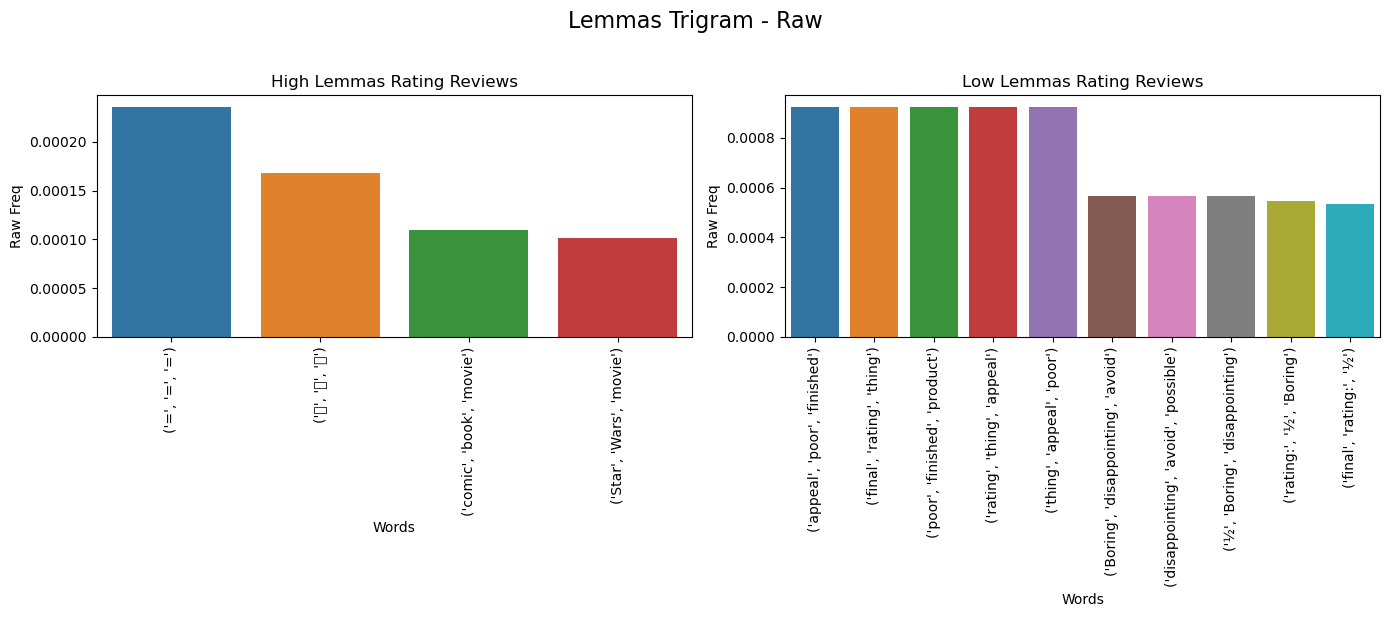

In [69]:
#lemmas raw trigram
plot_ngrams(lemmas_trigram_raw, title='Lemmas Trigram - Raw',
            first_col_group='High Lemmas Rating Reviews', 
            second_col_group='Low Lemmas Rating Reviews', 
            freq_type='Raw Freq')

##### Lemmas Bigram Raw vs Lemmas Trigram Analysis Raw: 
The same potential issue seen initialy for Token is seen for Lemmas as well. Although we have one additional column for trigram, it could still cause potential issues on mismatched ratings.  

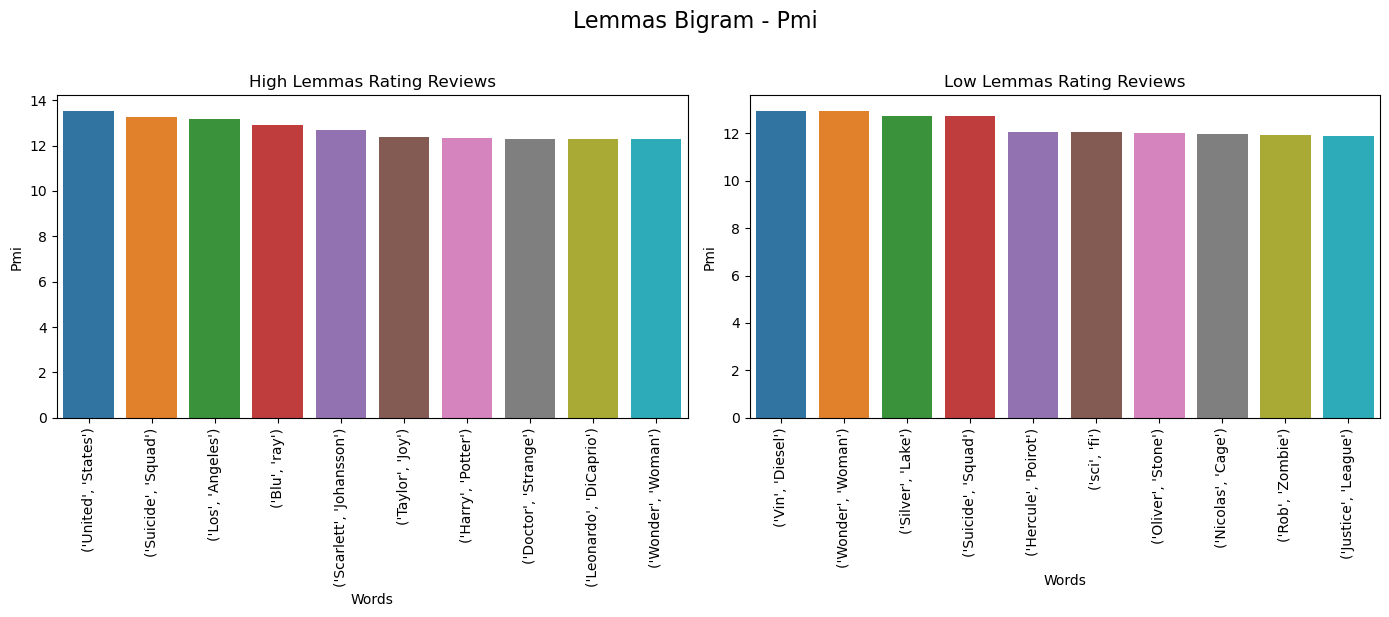

In [70]:
#lemmas pmi bigram
plot_ngrams(lemmas_bigram_pmi, title='Lemmas Bigram - Pmi',
            first_col_group='High Lemmas Rating Reviews', 
            second_col_group='Low Lemmas Rating Reviews', 
            freq_type='Pmi')

/var/folders/tc/tt7jrftn7g510vxnf1thdhl80000gn/T/ipykernel_55383/1440420602.py:35: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  plt.tight_layout()
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


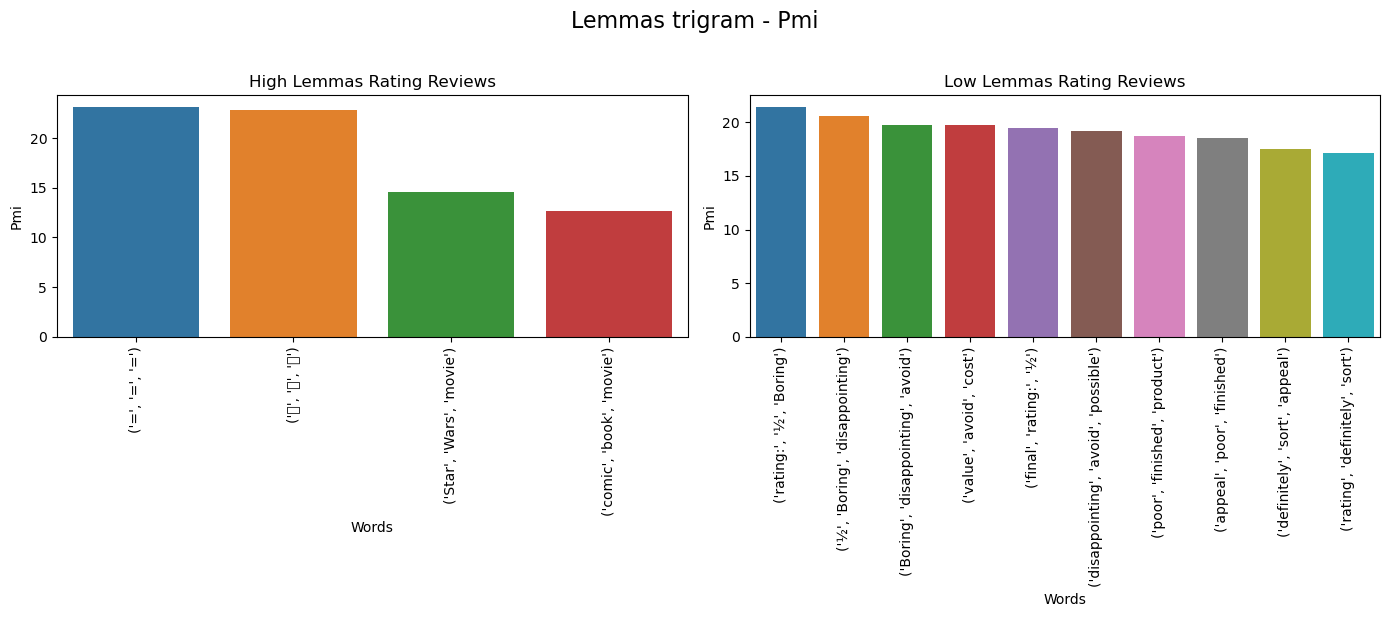

In [71]:
#lemmas pmi trigram
plot_ngrams(lemmas_trigram_pmi, title='Lemmas trigram - Pmi',
            first_col_group='High Lemmas Rating Reviews', 
            second_col_group='Low Lemmas Rating Reviews', 
            freq_type='Pmi')

##### Lemmas Bigram PMI vs Lemmas Trigram Analysis PMI: 
The same potential issue seen initialy for Token and Lemmas Raw is seen here. Although we have one additional column for trigram for word patterns, it could still cause potential issues on mismatched ratings.

### Sentiment Analysis

In [72]:
#download the vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/chas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [73]:
sia = SentimentIntensityAnalyzer()

In [74]:
df_clean.head()

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, addin...","[ok, huge, temptation, riddle, review, pun, go, crack, littl

In [75]:
#use the sia object to define a dictionary of polarity scores
df_clean['sentiment_scores'] = df_clean['review'].map(sia.polarity_scores)
#convert the column of dictionaries into separate columns
scores = df_clean['sentiment_scores'].apply(pd.Series)
#Join the new DataFrame with the original DataFrame
df_vader = pd.concat([df_clean, scores],
                           axis=1).drop('sentiment_scores', axis=1)
df_vader

/var/folders/tc/tt7jrftn7g510vxnf1thdhl80000gn/T/ipykernel_55383/4283719061.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sentiment_scores'] = df_clean['review'].map(sia.polarity_scores)


,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined,neg,neu,pos,compound
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...,0.068,0.744,0.188,0.9908
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation,0.053,0.587,0.360,0.9450
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend,0.071,0.776,0.153,0.7006
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngo

In [76]:
#create positive review filter
pos_sentiment_reviews = df_vader['compound'] > 0
pos_sentiment_reviews.sum()

5026

In [77]:
#identify reviews with a pos sentiment that received a bad review
filter_mismatch_A = (df_vader['rating_category']=="Low") & pos_sentiment_reviews
filter_mismatch_A.sum()

525

In [78]:
#create negative review filter
neg_sentiment_reviews = df_vader['compound'] < 0
neg_sentiment_reviews.sum()

1535

In [79]:
#identify reviews with a neg sentiment that received a good review
filter_mismatch_B = (df_vader['rating_category']=="High") & neg_sentiment_reviews
filter_mismatch_B.sum()

118

In [80]:
pos_sent_low = df_vader.loc[filter_mismatch_A, ['review', 'rating', 'compound']]
pos_sent_low.head()

,review,rating,compound
72,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was mad...",4.0,0.8695
111,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to...",4.0,0.6523
125,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short c...",3.0,0.9967
132,"After writing three high-praise reviews, I tried to think of the worst movie that I'd ever sat through and this movie came to mind, front and center. I've sat through plenty of ""chick flicks"" but even by chick flick standards this one is just hor...",1.0,0.9408
148,"I remember loving this film as a kid. Rewatching the film as an adult, the film does not hold up. I really remember the third act of the film before rewatching the film and it is going to be the only thing I will remember about the film. There ar...",4.0,0.7845


In [81]:
pd.set_option('display.max_colwidth', 1000)
pos_sent_low.loc[72]

review      WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like something that could have been believable in the 80's but not for the 2000s, rape kits and a thorough investigation solves the plot. It's pretty to look at and the cast is excellent but the rest of it is unbelievable.
rating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

#### Analysis: 
There are some seemingly positive terms here like "great", "excellent", and "unbelieavle", but upon further reading, we can see the customer thought the film was cheap and thought it was out of its time

In [82]:
neg_sent_high = df_vader.loc[filter_mismatch_B,['review', 'rating', 'compound']]
neg_sent_high.head()

,review,rating,compound
22,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",9.0,-0.3391
59,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",10.0,-0.5574
75,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows four people through their addictions until the shattering denouement, but the journey is made more bleak by offering tantalising snatches of hope, the dreams of the protags offered up as some sort of goals for the addicts to cling on to - only for the narrative to stick in its rusty serrated blade to draw the lifeblood from the hapless hopefuls.\r\n\r\nArononfsky brings a multitude of technical skills to the party that emphasise the emotional discord on show. Standard split-screening is married up with rapid cutting, isolated framing, close ups, long tracking and Snorricam, all of which is sound tracked by Clint Mansell's haunting musical composition. All told it's an assault on all the senses...",9.0,-0.7907
117,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on board. But pretty soon after the disaster strange accidents start to befall those who got off the plane, it seems that death is out to get them.\r\n\r\nWith the number of hugely disappointing teens in peril movies that were made post the success of Wes Craven's hugely successful Scream, it's refreshing to find one that was, well, refreshing. Not purporting to be anything other than a wickedly entertaining piece of horror based nonsense, Final Destination is inventive, funny and above all else, shock laden.\r\n\r\nFrom the opening, and terrifying air crash sequence to the clever and gross way that our protagonists shake hands with the grim reaper, this film is gloriously proud of its horror ...",9.0,-0.9920
254,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson, Helen Mirren, Tom Noonan, Benicio Del Toro, Mickey Rourke, Dale Dickey, Vanessa Redgrave and Harry Dean Stanton. Music is by Klaus Badelt and Hans Zimmer, and cinematography by Chris Menges.\r\n\r\nPolice chief Jerry Black (Nicholson) is literally on his last day before retitement. But during his leaving party news filters through that a young girl has been brutally murdered. Talking his chiefs into letting him tag along to the crime scene, Black ends up breaking the dredful news to the girl's parents. There he pledges to the mother that he will find her daughter's killer.\r\n\r\nDürrenmatt's source material has been mined a few times for other filmic ventures, where the best of the other b...",9.0,-0.9755


In [83]:
neg_sent_high.loc[75]

review      Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows four people through their addictions until the shattering denouement, but the journey is made more bleak by offering tantalising snatches of hope, the dreams of the protags offered up as some sort of goals for the addicts to cling on to - only for the narrative to stick in its rusty serrated blade to draw the lifeblood from the hapless hopefuls.\r\n\r\nArononfsky brings a multitude of technical skills to the party that emphasise the emotional discord on show. Standard split-screening is married up with rapid cutting, isolated framing, close ups, long tracking and Snorricam, all of which is sound tracked by Clint Mansell's haunting musical composition. All told it's an assault on all th

#### Analysis: 
There are some seemingly negative terms here like "fallible", "shattering", "tantalising", "bleak", and "rusty." Reading the review carefully, we can see the customer describing the movie in fine detail, which, based on its description, seems like a dark and emotional movie. 

## Evaluation and Reporting

### What should somoene do or not do if they want to make a high-rated movie?

Based on what was analyzed above, for a low rating we see bigrams like "poor, finished", "boring, disappointing", etc. It seems that movies that look unfinished and have poor graphics/special effects will have a negative impact on the rating of the movie. 

On the other hand, bigrams with a high review contain words like "comic, book", "special, effects", "sci, fi", etc. It seems that movies relating to comics, sci-fi and fantasy are regarded positively as long as they contain good special effects. The popularity of the actor, such as "john, wick" had a good effect on the rating so long as it also contains the bigrams mentioned. 